# July 2, 2024: nested communities of the hierarchical SBMs

In [1]:
import csv
import os
import sys
import numpy as np
import pandas as pd
import scipy as sp 
import pickle 
import copy

from scipy import sparse, stats
from scipy.special import gammaln
import glob
from tqdm import tqdm
import ants
from nipype.interfaces import afni
from itertools import combinations, permutations, product


import graph_tool.all as gt

# plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Rectangle
import colorcet as cc
from mpl_toolkits.mplot3d import Axes3D

plt.rcParamsDefault['font.family'] = "sans-serif"
plt.rcParamsDefault['font.sans-serif'] = "Arial"
plt.rcParams['font.size'] = 14
plt.rcParams["errorbar.capsize"] = 0.5

import colorcet as cc
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import colors

import cmasher as cmr  # CITE ITS PAPER IN YOUR MANUSCRIPT

# ignore user warnings
import warnings
warnings.filterwarnings("ignore") #, category=UserWarning)

240702-13:12:15,620 nipype.utils WARNING:
	 A newer version (1.8.4) of nipy/nipype is available. You are using 1.6.1


In [2]:
class ARGS():
    pass

args = ARGS()

args.SEED = 100

gt.seed_rng(args.SEED)
np.random.seed(args.SEED)

In [3]:
args.type = 'spatial'
args.roi_size = 225
args.maintain_symmetry = True
args.brain_div = 'whl'
args.num_rois = 162

DESC = (
    f'type-{args.type}'
    f'_size-{args.roi_size}'
    f'_symm-{args.maintain_symmetry}'
    f'_braindiv-{args.brain_div}'
    f'_nrois-{args.num_rois}'
)

args.unit = 'seswise' # runwise/seswise/subwise : unit sample of dataset
args.denst = 25 # density of fc matrix

BASE_path = f'{os.environ["HOME"]}/mouse_dataset'
PARCELS_path = f'{BASE_path}/parcels'
ROI_path = f'{BASE_path}/roi_results'
RECONST_method = '' #f'lds' #f'normal_dist'
if RECONST_method == '':
    GRAPH_type = f'correlation_graph'
    ROI_RESULTS_path = f'{ROI_path}/{DESC}/{args.unit}/{GRAPH_type}/density-{args.denst}'
    FC_path = f'{ROI_RESULTS_path}/corr_mats'
else: 
    GRAPH_type = f'reconstructed_graph/{RECONST_method}'
    ROI_RESULTS_path = f'{ROI_path}/{DESC}/{args.unit}/{GRAPH_type}'
    GRAPHS_path = f'{ROI_RESULTS_path}/graphs'

SBM_path = f'{ROI_RESULTS_path}/sbms'
NPY_path = f'{ROI_RESULTS_path}/npy'
os.system(f'mkdir -p {NPY_path}')
NII_path = f'{ROI_RESULTS_path}/niis'
os.system(f'mkdir -p {NII_path}/indiv')
os.system(f'mkdir -p {NII_path}/group/soft')
os.system(f'mkdir -p {NII_path}/group/entropy')
PNG_path = f'{ROI_RESULTS_path}/png'
os.system(f'mkdir -p {PNG_path}/group/morphospace')
HTML_path = f'{ROI_RESULTS_path}/htmls'
os.system(f'mkdir -p {HTML_path}/group/soft/indexes')
os.system(f'mkdir -p {HTML_path}/group/soft/partitions/hierarchical')
CSV_path = f'{ROI_RESULTS_path}/csv'
os.system(f'mkdir -p {CSV_path}/group/roi_order')

0

In [4]:
def load_modes(args, model):
    args.dc, args.sbm = model
    SBM = f'sbm-{args.dc}-{args.sbm}'
    with open(f'{NPY_path}/{SBM}_desc-group-modes.npy', 'rb') as f:
        [dfs, mode_df] = pickle.load(f)
    return args, SBM, dfs, mode_df

In [5]:
def combine_soft_htmls(args, SBM, html_files, idx_mode, level=1, COMM=0):
    # Create the main HTML content
    html_content = """
    <!DOCTYPE html>
    <html lang="en">
    <head>
        <meta charset="UTF-8">
        <meta name="viewport" content="width=device-width, initial-scale=1.0">
        <title>HTML Grid with Headings</title>
        <style>
            body {
                display: grid;
                grid-template-columns: repeat(auto-fill, minmax(1000px, 1fr));
                gap: 20px;
                padding: 20px;
            }
            iframe {
                width: 850px;
                height: 850px;
                border: none;
            }
            .grid-item {
                text-align: center;
                margin-bottom: 10px;
            }
            h2 {
                margin: 0;
            }
        </style>
    </head>
    <body>
    """
    # Add iframes and headings for each HTML file
    for html_file in html_files:
        # Extract filename (without extension) for heading
        filename, _ = os.path.splitext(html_file.split('/')[-1])
        heading = f'<h2>{filename}</h2>'  # Capitalize the filename for title
        iframe_tag = f'<div class="grid-item">{heading}<iframe src="{html_file}"></iframe></div>'
        html_content += iframe_tag
    # Close the HTML content
    html_content += """
    </body>
    </html>
    """
    # Write the content to an index.html file
    index_file = os.path.join(f'{HTML_path}/group/soft/partitions/hierarchical', f"{SBM}_mode-{idx_mode}_level-{level}_comm-{COMM}_desc-index.html")
    with open(index_file, "w") as f:
        f.write(html_content)
    print("index.html has been created successfully.")

In [6]:
models_list = [
    ('dc', 'h'),
    ('nd', 'h'),
]

In [7]:
for model in models_list:
    args, SBM, dfs, mode_df = load_modes(args, model=model)
    print(f'{SBM}')
    for idx_mode, row in mode_df.iterrows():
        print(f'mode {idx_mode}')
        bs_df = pd.read_csv(
            f'{CSV_path}/group/roi_order/{SBM}_mode-{idx_mode}_desc-roi-order.csv', 
            sep='\t',
        )
        for COMM in bs_df['1'].unique():
            comms = bs_df[bs_df['1'] == COMM]['0'].unique()
            html_files = [f'{HTML_path}/group/soft/{SBM}_level-{0}_desc-soft-comm-{comm:02d}.html' for comm in comms]
            combine_soft_htmls(args, SBM, html_files, idx_mode, level=1, COMM=COMM)

sbm-dc-h
mode 0
index.html has been created successfully.
index.html has been created successfully.
index.html has been created successfully.
mode 1
index.html has been created successfully.
index.html has been created successfully.
index.html has been created successfully.
mode 2
index.html has been created successfully.
index.html has been created successfully.
index.html has been created successfully.
mode 3
index.html has been created successfully.
index.html has been created successfully.
mode 4
index.html has been created successfully.
index.html has been created successfully.
index.html has been created successfully.
mode 5
index.html has been created successfully.
index.html has been created successfully.
index.html has been created successfully.
mode 6
index.html has been created successfully.
index.html has been created successfully.
index.html has been created successfully.
index.html has been created successfully.
index.html has been created successfully.
mode 7
index.html 

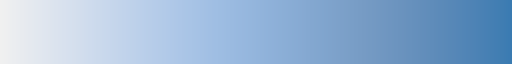

In [9]:
cc.cm.CET_L12